In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2

# enables the %%R magic that can switch to R code model
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [87]:
df = pd.read_csv('cookie_cats.csv')
print("Number of rows of df is", df.shape[0], 'and number of columns is', df.shape[1])


Number of rows of df is 90189 and number of columns is 5


## Data exploration

### Missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
userid            90189 non-null int64
version           90189 non-null object
sum_gamerounds    90189 non-null int64
retention_1       90189 non-null bool
retention_7       90189 non-null bool
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


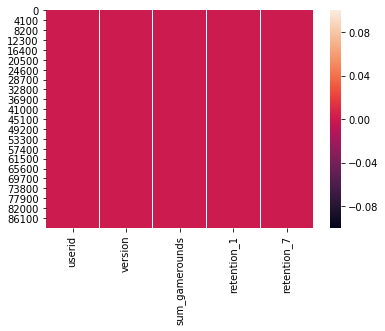

In [88]:
# check missing values
df.info()

sns.heatmap(df.isnull())


Both the summary and plot show that we do not have missing values in our dataset, which is good.

### Distribution of game version
Let's check the  values on each games version

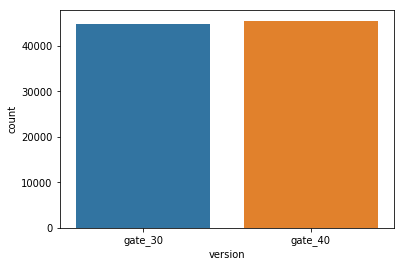

In [89]:
# count of values in each group
df.groupby('version').count()

# plot the count plot
sns.countplot(x = "version", data = df)

The numbers of users of version gate_30 and gate_40 are pretty much equal. 

### Distribution of game rounds vs number of users




In [90]:
# count how many users that complete the sum gamerounds

df_plot = df.groupby('sum_gamerounds').count().reset_index()
df_plot.head()

,sum_gamerounds,userid,version,retention_1,retention_7
0,0,3994,3994,3994,3994
1,1,5538,5538,5538,5538
2,2,4606,4606,4606,4606
3,3,3958,3958,3958,3958
4,4,3629,3629,3629,3629


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



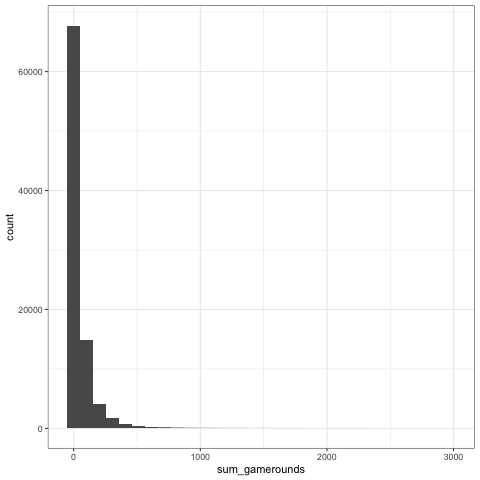

In [91]:
%%R -i df 
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

#install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)
ggplot(filter(df, sum_gamerounds <10000), aes(sum_gamerounds)) + geom_histogram()  + theme_bw()


There are big portion of users do not play any rounds after installing the games.

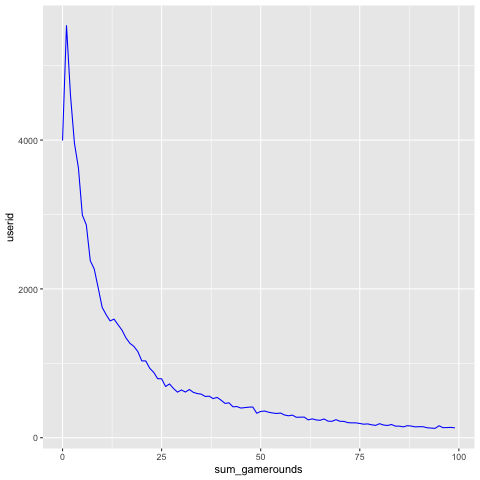

In [92]:
%%R -i df_plot 
# relationship between number of rounds vs number of users

ggplot(filter(df_plot, sum_gamerounds <10000), aes(x = sum_gamerounds, y = userid)) + geom_point()

ggplot(head(df_plot, 100), aes(x = sum_gamerounds, y = userid)) + geom_line(color = 'blue')

## Data analysis

### Version vs sum_gamerounds

Let's explore what are the differences in total round of games between 2 versions of game

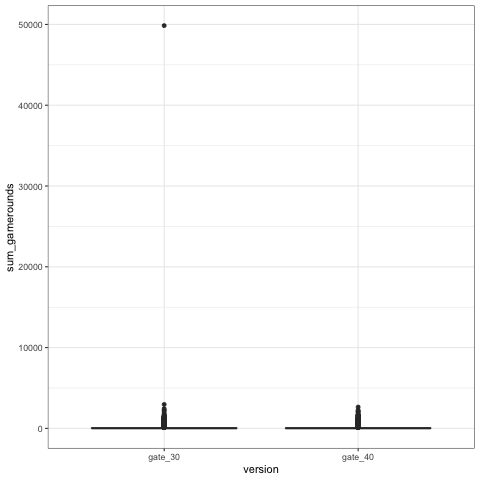

In [111]:
%%R -i df
theme_set(theme_bw())

ggplot(df, aes(version, sum_gamerounds)) + geom_boxplot(fill = 'light blue')

Clearly , there is a big outliers in our dataset. While most of users play less than 5000 rounds , there is one user plays 50000 rounds approximately.
Let's remove it out of dataset we can have better clear of the population.


In [114]:
df = df[df['sum_gamerounds'] < 5000]

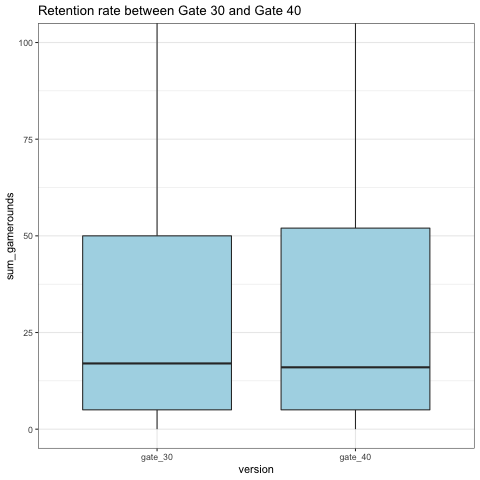

In [170]:
%%R -i df
theme_set(theme_bw())
# plot the boxplot and scale to see compare the median values
ggplot(df, aes(version, sum_gamerounds)) + 
    geom_boxplot(fill = 'light blue')+ 
    scale_y_continuous() + 
    coord_cartesian(ylim = c(0, 100)) + 
    labs(title = 'Retention rate between Gate 30 and Gate 40')


Based on the boxplot above, the median values of total game rounds in gate 30 is slighly higher than in gate 40.
This measn that users tend to play more games (leading to higher rounds )in gate 30 than that of gate 40.


### Retention  after one day
Let's compute the average of retention after 1 day in overall, not taking into account the difference between gate 30 and gate 40.

In [138]:
avg_1day = df['retention_1'].mean()
print('The percentage of users come back and play game (retention == True) after one day is:', round(avg_1day*100, 2), '%')

The percentage of users come back and play game (retention == True) after one day is: 44.52 %


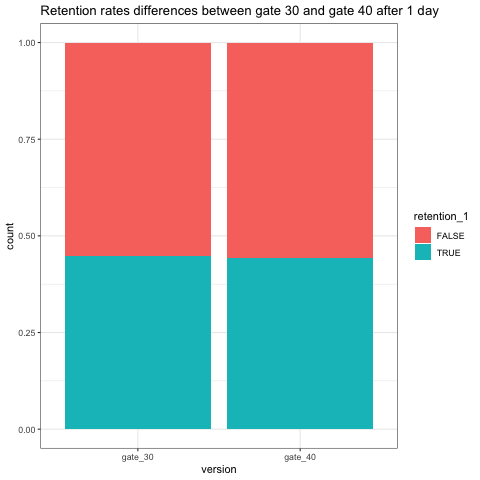

In [183]:
%%R -i df
theme_set(theme_bw())
# plot the boxplot and scale to see compare the median values
ggplot(df) + 
    geom_bar(aes(x = version, fill = retention_1), position = 'fill') +
    ggtitle('Retention rates differences between gate 30 and gate 40 after 1 day')

In [139]:
avg_1day_group = df.groupby('version')['retention_1'].mean()
print('Average of users come back and play game in version 30 is:', round(avg_1day_group[0]*100, 2),'%')
print('Average of users come back and play game in version 40 is:', round(avg_1day_group[1]*100, 2),'%')

Average of users come back and play game in version 30 is: 44.82 %
Average of users come back and play game in version 40 is: 44.23 %


Based on the above, the retention of version 30 is slightly higher than version 40.

Let's check the total of game rounds when retention of day 1 is True for both gate 30 and gate 40

In [181]:
# filter gate 30 dataset
gate_30 = df[df['version'] == 'gate_30']
gate_30_rounds_True = gate_30[gate_30['retention_1'] == True]['sum_gamerounds'].sum() / gate_30['sum_gamerounds'].sum()

# filter gate 40 dataset
gate_40 = df[df['version'] == 'gate_40']
gate_40_rounds_True = gate_40[gate_40['retention_1'] == True]['sum_gamerounds'].sum() / gate_40['sum_gamerounds'].sum()

# compare the game rounds when retention is YTrue for both games
print(r'In addition to retention is higher in gate 30, users tent to play more game rounds in gate 30 too?', gate_30_rounds_True > gate_40_rounds_True)

In addition to retention is higher in gate 30, users tent to play more game rounds in gate 30 too? True


### Retention  after seven days

In [146]:
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

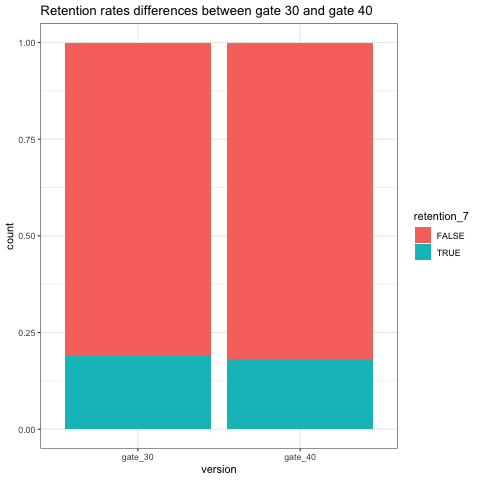

In [177]:
%%R -i df
theme_set(theme_bw())
# plot the boxplot and scale to see compare the median values
ggplot(df) + 
    geom_bar(aes(x = version, fill = retention_7), position = 'fill') +
    ggtitle('Retention rates differences between gate 30 and gate 40 after 7 days')

From the above, we could see albeit small, the rention rate of gate 30 is still higher than that of gate 40.
Let's double check the total rounds that user play.

In [178]:
# filter gate 30 dataset
gate_30 = df[df['version'] == 'gate_30']
gate_30_rounds_True = gate_30[gate_30['retention_7'] == True]['sum_gamerounds'].sum() / gate_30['sum_gamerounds'].sum()

# filter gate 40 dataset
gate_40 = df[df['version'] == 'gate_40']
gate_40_rounds_True = gate_40[gate_40['retention_7'] == True]['sum_gamerounds'].sum() / gate_40['sum_gamerounds'].sum()

# compare the game rounds when retention is YTrue for both games
print(r'In addition to retention is higher in gate 30, users tent to play more game rounds in gate 30?', gate_30_rounds_True > gate_40_rounds_True)

In addition to retention is higher in gate 30, users tent to play more game rounds in gate 30 too? True


## Boostrap resampling to confirm the difference

Boostrap is a technique to measure the certaintly of a given conclusion. In other words, if we conclude that retention rate is higher in gate 30 than gate 40, we might want to repeat the process of quantify the analyze the difference between 2 gates on many samples .